Package imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

Explore directory to figure out what is where

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pokemon-images-and-types/pokemon.csv
/kaggle/input/pokemon-images-and-types/images/images/horsea.png
/kaggle/input/pokemon-images-and-types/images/images/lotad.png
/kaggle/input/pokemon-images-and-types/images/images/klefki.png
/kaggle/input/pokemon-images-and-types/images/images/gumshoos.jpg
/kaggle/input/pokemon-images-and-types/images/images/oshawott.png
/kaggle/input/pokemon-images-and-types/images/images/furret.png
/kaggle/input/pokemon-images-and-types/images/images/sneasel.png
/kaggle/input/pokemon-images-and-types/images/images/nidoking.png
/kaggle/input/pokemon-images-and-types/images/images/ribombee.jpg
/kaggle/input/pokemon-images-and-types/images/images/charjabug.jpg
/kaggle/input/pokemon-images-and-types/images/images/unfezant.png
/kaggle/input/pokemon-images-and-types/images/images/timburr.png
/kaggle/input/pokemon-images-and-types/images/images/furfrou.png
/kaggle/input/pokemon-images-and-types/images/images/durant.png
/kaggle/input/pokemon-images-and-types

Load the info data frame and look around

In [3]:
manifest=pd.read_csv('/kaggle/input/pokemon-images-and-types/pokemon.csv')

In [4]:
manifest.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [5]:
manifest.describe()

,Name,Type1,Type2
count,809,809,405
unique,809,18,18
top,fearow,Water,Flying
freq,1,114,95


Confirm that type 2 is only column with NaNs

In [6]:
np.any(manifest.Name.isna()),np.any(manifest.Type1.isna()),np.any(manifest.Type2.isna())

(False, False, True)

Add a class for missing values

In [7]:
manifest.Type2[manifest.Type2.isna()] = "No Second Type"

One-hot encode *y*s

In [8]:
y1=pd.get_dummies(manifest.Type1)

In [9]:
y2=pd.get_dummies(manifest.Type2)

In [10]:
y1.head()

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [11]:
y2

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,No Second Type,Normal,Poison,Psychic,Rock,Steel,Water
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
805,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
806,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
807,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


I just rearranged the columns here, but turns out it might not have been necessary

In [12]:
fixcols=y2.columns.tolist()[0:12]
for i in y2.columns.tolist()[13:19]:
    fixcols.append(i)
fixcols.append(y2.columns.tolist()[12])
y2=y2[fixcols]

Add a column for 'No second type' class to first class, to allow combining the two sets

In [13]:
y1['No Second Type']=0

In [14]:
y1.values.shape,y2.values.shape
y2+y1

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,No Second Type
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
805,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
806,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


Concatenate the pokemon names with their one-hot encoded types

In [15]:
manifest=pd.concat([manifest['Name'].reset_index(drop=True), y2+y1], axis=1)

In [16]:
manifest

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,No Second Type
0,bulbasaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,ivysaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,venusaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,charmander,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,charmeleon,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,stakataka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
805,blacephalon,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
806,zeraora,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
807,meltan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


Look at an example image and find out array dimensions

<class 'PIL.Image.Image'>
float32
(120, 120, 3)


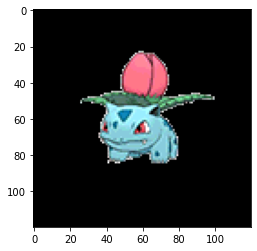

In [17]:
# load an example image
img = load_img('/kaggle/input/pokemon-images-and-types/images/images/ivysaur.png')
print(type(img))
# convert to numpy array
img_array = img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
#show image
plt.imshow(img);

Check pixel value range

In [18]:
np.max(img_array)

255.0

Obtain and normalise x values between (0,1)

In [19]:
names=[]
index=0

for dirname, _, filenames in os.walk('/kaggle/input/pokemon-images-and-types/images/images/'):
    for filename in filenames:
        file_path_i = os.path.join(dirname, filename)
        name_i = filename.replace('.png','')
        names.append({'Name':name_i,'ix':index})
        if index==0:
            x=load_img(file_path_i)
            x=img_to_array(x)
            x.shape=(1,120,120,3)
            x=x/255.
        else:
            xi=load_img(file_path_i)
            xi=img_to_array(xi)
            xi.shape=(1,120,120,3)
            xi=xi/255.
            x = np.concatenate((x,xi),axis=0)
        index+=1
        #print(index)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [20]:
names=pd.DataFrame(names)

In [21]:
names.head()

,Name,ix
0,horsea,0
1,lotad,1
2,klefki,2
3,gumshoos.jpg,3
4,oshawott,4


Here I was just figuring out why merging on Name resulted in dropped values, turns out there are some images for which there is no data in the manifest, so ended up dropping those

In [22]:
len(names.Name.unique()),len(manifest.Name.unique()),len(names.ix.unique())

(809, 809, 809)

In [23]:
manifest=manifest.merge(names,how='left')

In [24]:
np.where(manifest.ix.isna())

(array([721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733,
        734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746,
        747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759,
        760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772,
        773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785,
        786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798,
        799, 800, 801, 802, 803, 804, 805, 806, 807, 808]),)

In [25]:
len(os.listdir('/kaggle/input/pokemon-images-and-types/images/images/'))

809

In [26]:
missing=[]
for i in manifest[manifest.ix.isna()].Name.values:
    missing.append(i in names.Name)
np.any(missing)

False

In [27]:
dropme=np.where(manifest.ix.isna())

In [28]:
dropme

(array([721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733,
        734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746,
        747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759,
        760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772,
        773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785,
        786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798,
        799, 800, 801, 802, 803, 804, 805, 806, 807, 808]),)

In [29]:
manifest.dropna(inplace=True)

In [30]:
manifest = manifest.set_index('ix',drop=True).sort_index()

In [31]:
manifest

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,No Second Type
ix,,,,,,,,,,,,,,,,,,,,
0.0,horsea,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1.0,lotad,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2.0,klefki,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4.0,oshawott,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
5.0,furret,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801.0,swoobat,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
802.0,bastiodon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
803.0,mantine,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [32]:
np.delete(x,dropme,axis=0).shape

(721, 120, 120, 3)

In [33]:
x= np.delete(x,dropme,axis=0)

In [34]:
manifest.drop('Name',axis=1).values.shape

(721, 19)

In [35]:
y=manifest.drop('Name',axis=1).values

In [36]:
type(y),type(x)

(numpy.ndarray, numpy.ndarray)

In [37]:
x = np.float32(x)

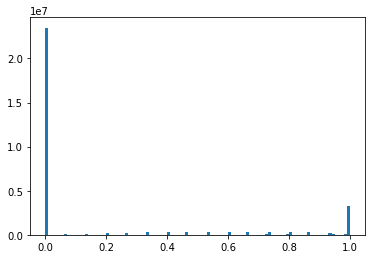

In [38]:
plt.hist(x.ravel(),bins=100);

**First model**

In [39]:
model = Sequential()
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='tanh',input_shape=(x.shape[1],x.shape[2],x.shape[3])))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(y.shape[1],activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0

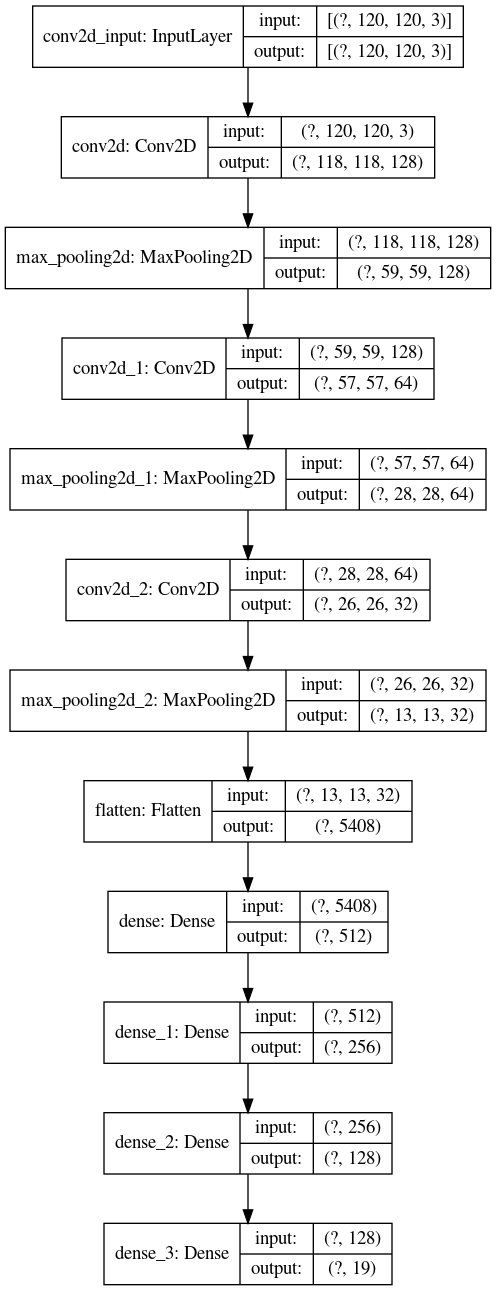

In [41]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [46]:
adam=tf.keras.optimizers.Adam(
    learning_rate=0.0000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)

In [47]:
model.compile(optimizer=adam,
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
     x, y, test_size=0.15, random_state=42)

In [49]:
history = model.fit(X_train,y_train,batch_size=32,epochs=200,validation_split=0.15,shuffle=True)

Epoch 1/200
17/17 [==============================] - 0s 28ms/step - loss: 0.6983 - top_k_categorical_accuracy: 0.1096 - val_loss: 0.6992 - val_top_k_categorical_accuracy: 0.0761
Epoch 2/200
17/17 [==============================] - 0s 21ms/step - loss: 0.6981 - top_k_categorical_accuracy: 0.1077 - val_loss: 0.6989 - val_top_k_categorical_accuracy: 0.0652
Epoch 3/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6978 - top_k_categorical_accuracy: 0.1019 - val_loss: 0.6987 - val_top_k_categorical_accuracy: 0.0652
Epoch 4/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6976 - top_k_categorical_accuracy: 0.1019 - val_loss: 0.6985 - val_top_k_categorical_accuracy: 0.0652
Epoch 5/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6973 - top_k_categorical_accuracy: 0.1038 - val_loss: 0.6982 - val_top_k_categorical_accuracy: 0.0652
Epoch 6/200
17/17 [==============================] - 0s 21ms/step - loss: 0.6971 - top_k_categorical_accuracy:

Epoch 47/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6872 - top_k_categorical_accuracy: 0.1308 - val_loss: 0.6885 - val_top_k_categorical_accuracy: 0.0870
Epoch 48/200
17/17 [==============================] - 0s 21ms/step - loss: 0.6869 - top_k_categorical_accuracy: 0.1346 - val_loss: 0.6882 - val_top_k_categorical_accuracy: 0.0870
Epoch 49/200
17/17 [==============================] - 0s 22ms/step - loss: 0.6867 - top_k_categorical_accuracy: 0.1327 - val_loss: 0.6880 - val_top_k_categorical_accuracy: 0.0870
Epoch 50/200
17/17 [==============================] - 0s 22ms/step - loss: 0.6864 - top_k_categorical_accuracy: 0.1327 - val_loss: 0.6878 - val_top_k_categorical_accuracy: 0.0870
Epoch 51/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6862 - top_k_categorical_accuracy: 0.1327 - val_loss: 0.6875 - val_top_k_categorical_accuracy: 0.0870
Epoch 52/200
17/17 [==============================] - 0s 21ms/step - loss: 0.6860 - top_k_categorical_acc

Epoch 93/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6756 - top_k_categorical_accuracy: 0.1365 - val_loss: 0.6771 - val_top_k_categorical_accuracy: 0.0978
Epoch 94/200
17/17 [==============================] - 0s 22ms/step - loss: 0.6753 - top_k_categorical_accuracy: 0.1385 - val_loss: 0.6769 - val_top_k_categorical_accuracy: 0.0870
Epoch 95/200
17/17 [==============================] - 0s 21ms/step - loss: 0.6750 - top_k_categorical_accuracy: 0.1385 - val_loss: 0.6766 - val_top_k_categorical_accuracy: 0.0870
Epoch 96/200
17/17 [==============================] - 0s 22ms/step - loss: 0.6747 - top_k_categorical_accuracy: 0.1385 - val_loss: 0.6763 - val_top_k_categorical_accuracy: 0.0870
Epoch 97/200
17/17 [==============================] - 0s 21ms/step - loss: 0.6745 - top_k_categorical_accuracy: 0.1404 - val_loss: 0.6761 - val_top_k_categorical_accuracy: 0.0870
Epoch 98/200
17/17 [==============================] - 1s 31ms/step - loss: 0.6742 - top_k_categorical_acc

17/17 [==============================] - 0s 22ms/step - loss: 0.6463 - top_k_categorical_accuracy: 0.1019 - val_loss: 0.6485 - val_top_k_categorical_accuracy: 0.0870
Epoch 184/200
17/17 [==============================] - 0s 21ms/step - loss: 0.6459 - top_k_categorical_accuracy: 0.1019 - val_loss: 0.6481 - val_top_k_categorical_accuracy: 0.0870
Epoch 185/200
17/17 [==============================] - 0s 21ms/step - loss: 0.6455 - top_k_categorical_accuracy: 0.1019 - val_loss: 0.6477 - val_top_k_categorical_accuracy: 0.0870
Epoch 186/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6451 - top_k_categorical_accuracy: 0.1038 - val_loss: 0.6473 - val_top_k_categorical_accuracy: 0.0870
Epoch 187/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6447 - top_k_categorical_accuracy: 0.1038 - val_loss: 0.6470 - val_top_k_categorical_accuracy: 0.0870
Epoch 188/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6443 - top_k_categorical_accuracy: 0

In [51]:
print(history.history.keys())

dict_keys(['loss', 'top_k_categorical_accuracy', 'val_loss', 'val_top_k_categorical_accuracy'])


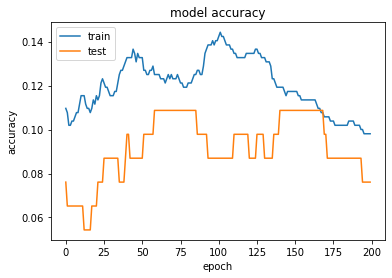

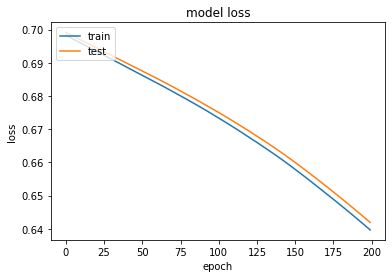

In [53]:
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Second model**

In [54]:
model = Sequential()
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='tanh',input_shape=(x.shape[1],x.shape[2],x.shape[3])))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(y.shape[1],activation='sigmoid'))

adam=tf.keras.optimizers.Adam(
    learning_rate=0.0000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)

model.compile(optimizer=adam,
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
history = model.fit(X_train,y_train,batch_size=32,epochs=1000,validation_split=0.15,shuffle=True)

Epoch 1/1000
17/17 [==============================] - 1s 32ms/step - loss: 0.7020 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.7017 - val_top_k_categorical_accuracy: 0.2283
Epoch 2/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.7019 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.7016 - val_top_k_categorical_accuracy: 0.2283
Epoch 3/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.7018 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.7015 - val_top_k_categorical_accuracy: 0.2283
Epoch 4/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.7018 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.7015 - val_top_k_categorical_accuracy: 0.2283
Epoch 5/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.7017 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.7014 - val_top_k_categorical_accuracy: 0.2283
Epoch 6/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.7016 - top_k_categorical_acc

17/17 [==============================] - 0s 21ms/step - loss: 0.6965 - top_k_categorical_accuracy: 0.1923 - val_loss: 0.6964 - val_top_k_categorical_accuracy: 0.1630
Epoch 92/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6965 - top_k_categorical_accuracy: 0.1942 - val_loss: 0.6964 - val_top_k_categorical_accuracy: 0.1630
Epoch 93/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6964 - top_k_categorical_accuracy: 0.1942 - val_loss: 0.6963 - val_top_k_categorical_accuracy: 0.1630
Epoch 94/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6963 - top_k_categorical_accuracy: 0.1962 - val_loss: 0.6963 - val_top_k_categorical_accuracy: 0.1630
Epoch 95/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6963 - top_k_categorical_accuracy: 0.1962 - val_loss: 0.6962 - val_top_k_categorical_accuracy: 0.1630
Epoch 96/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6962 - top_k_categorical_accuracy: 0

17/17 [==============================] - 0s 21ms/step - loss: 0.6921 - top_k_categorical_accuracy: 0.1885 - val_loss: 0.6922 - val_top_k_categorical_accuracy: 0.1196
Epoch 182/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6921 - top_k_categorical_accuracy: 0.1885 - val_loss: 0.6921 - val_top_k_categorical_accuracy: 0.1196
Epoch 183/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6920 - top_k_categorical_accuracy: 0.1885 - val_loss: 0.6921 - val_top_k_categorical_accuracy: 0.1196
Epoch 184/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6920 - top_k_categorical_accuracy: 0.1885 - val_loss: 0.6920 - val_top_k_categorical_accuracy: 0.1196
Epoch 185/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6919 - top_k_categorical_accuracy: 0.1885 - val_loss: 0.6920 - val_top_k_categorical_accuracy: 0.1196
Epoch 186/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6919 - top_k_categorical_accura

17/17 [==============================] - 0s 20ms/step - loss: 0.6870 - top_k_categorical_accuracy: 0.1962 - val_loss: 0.6871 - val_top_k_categorical_accuracy: 0.1413
Epoch 272/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6870 - top_k_categorical_accuracy: 0.1962 - val_loss: 0.6871 - val_top_k_categorical_accuracy: 0.1413
Epoch 273/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6869 - top_k_categorical_accuracy: 0.1962 - val_loss: 0.6870 - val_top_k_categorical_accuracy: 0.1413
Epoch 274/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.6869 - top_k_categorical_accuracy: 0.1962 - val_loss: 0.6869 - val_top_k_categorical_accuracy: 0.1304
Epoch 275/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.6868 - top_k_categorical_accuracy: 0.1962 - val_loss: 0.6869 - val_top_k_categorical_accuracy: 0.1304
Epoch 276/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6867 - top_k_categorical_accura

17/17 [==============================] - 0s 23ms/step - loss: 0.6806 - top_k_categorical_accuracy: 0.2038 - val_loss: 0.6807 - val_top_k_categorical_accuracy: 0.1522
Epoch 362/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6805 - top_k_categorical_accuracy: 0.2058 - val_loss: 0.6806 - val_top_k_categorical_accuracy: 0.1522
Epoch 363/1000
17/17 [==============================] - 0s 27ms/step - loss: 0.6804 - top_k_categorical_accuracy: 0.2077 - val_loss: 0.6805 - val_top_k_categorical_accuracy: 0.1522
Epoch 364/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.6803 - top_k_categorical_accuracy: 0.2077 - val_loss: 0.6804 - val_top_k_categorical_accuracy: 0.1522
Epoch 365/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6803 - top_k_categorical_accuracy: 0.2077 - val_loss: 0.6804 - val_top_k_categorical_accuracy: 0.1522
Epoch 366/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6802 - top_k_categorical_accura

17/17 [==============================] - 0s 21ms/step - loss: 0.6731 - top_k_categorical_accuracy: 0.2192 - val_loss: 0.6733 - val_top_k_categorical_accuracy: 0.1630
Epoch 452/1000
17/17 [==============================] - 0s 20ms/step - loss: 0.6730 - top_k_categorical_accuracy: 0.2192 - val_loss: 0.6732 - val_top_k_categorical_accuracy: 0.1630
Epoch 453/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6729 - top_k_categorical_accuracy: 0.2192 - val_loss: 0.6731 - val_top_k_categorical_accuracy: 0.1630
Epoch 454/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6729 - top_k_categorical_accuracy: 0.2192 - val_loss: 0.6731 - val_top_k_categorical_accuracy: 0.1630
Epoch 455/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6728 - top_k_categorical_accuracy: 0.2192 - val_loss: 0.6730 - val_top_k_categorical_accuracy: 0.1630
Epoch 456/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6727 - top_k_categorical_accura

17/17 [==============================] - 0s 21ms/step - loss: 0.6650 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.6653 - val_top_k_categorical_accuracy: 0.1522
Epoch 542/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6649 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.6652 - val_top_k_categorical_accuracy: 0.1522
Epoch 543/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.6648 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.6651 - val_top_k_categorical_accuracy: 0.1522
Epoch 544/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6647 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.6650 - val_top_k_categorical_accuracy: 0.1522
Epoch 545/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6646 - top_k_categorical_accuracy: 0.2212 - val_loss: 0.6649 - val_top_k_categorical_accuracy: 0.1522
Epoch 546/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6645 - top_k_categorical_accura

17/17 [==============================] - 0s 21ms/step - loss: 0.6560 - top_k_categorical_accuracy: 0.2173 - val_loss: 0.6565 - val_top_k_categorical_accuracy: 0.1413
Epoch 632/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6559 - top_k_categorical_accuracy: 0.2173 - val_loss: 0.6564 - val_top_k_categorical_accuracy: 0.1413
Epoch 633/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6558 - top_k_categorical_accuracy: 0.2173 - val_loss: 0.6563 - val_top_k_categorical_accuracy: 0.1413
Epoch 634/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6557 - top_k_categorical_accuracy: 0.2173 - val_loss: 0.6562 - val_top_k_categorical_accuracy: 0.1413
Epoch 635/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6556 - top_k_categorical_accuracy: 0.2173 - val_loss: 0.6561 - val_top_k_categorical_accuracy: 0.1413
Epoch 636/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6555 - top_k_categorical_accura

17/17 [==============================] - 0s 21ms/step - loss: 0.6467 - top_k_categorical_accuracy: 0.2135 - val_loss: 0.6473 - val_top_k_categorical_accuracy: 0.1630
Epoch 722/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6466 - top_k_categorical_accuracy: 0.2135 - val_loss: 0.6472 - val_top_k_categorical_accuracy: 0.1630
Epoch 723/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6465 - top_k_categorical_accuracy: 0.2135 - val_loss: 0.6470 - val_top_k_categorical_accuracy: 0.1630
Epoch 724/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6464 - top_k_categorical_accuracy: 0.2135 - val_loss: 0.6469 - val_top_k_categorical_accuracy: 0.1630
Epoch 725/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6463 - top_k_categorical_accuracy: 0.2135 - val_loss: 0.6468 - val_top_k_categorical_accuracy: 0.1630
Epoch 726/1000
17/17 [==============================] - 0s 20ms/step - loss: 0.6462 - top_k_categorical_accura

17/17 [==============================] - 0s 21ms/step - loss: 0.6370 - top_k_categorical_accuracy: 0.2058 - val_loss: 0.6377 - val_top_k_categorical_accuracy: 0.1630
Epoch 812/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6369 - top_k_categorical_accuracy: 0.2058 - val_loss: 0.6376 - val_top_k_categorical_accuracy: 0.1630
Epoch 813/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6368 - top_k_categorical_accuracy: 0.2058 - val_loss: 0.6375 - val_top_k_categorical_accuracy: 0.1630
Epoch 814/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6367 - top_k_categorical_accuracy: 0.2058 - val_loss: 0.6374 - val_top_k_categorical_accuracy: 0.1630
Epoch 815/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6366 - top_k_categorical_accuracy: 0.2058 - val_loss: 0.6373 - val_top_k_categorical_accuracy: 0.1630
Epoch 816/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6365 - top_k_categorical_accura

17/17 [==============================] - 0s 21ms/step - loss: 0.6270 - top_k_categorical_accuracy: 0.2058 - val_loss: 0.6277 - val_top_k_categorical_accuracy: 0.1630
Epoch 902/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6268 - top_k_categorical_accuracy: 0.2058 - val_loss: 0.6276 - val_top_k_categorical_accuracy: 0.1630
Epoch 903/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6267 - top_k_categorical_accuracy: 0.2058 - val_loss: 0.6275 - val_top_k_categorical_accuracy: 0.1630
Epoch 904/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.6266 - top_k_categorical_accuracy: 0.2077 - val_loss: 0.6274 - val_top_k_categorical_accuracy: 0.1630
Epoch 905/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.6265 - top_k_categorical_accuracy: 0.2077 - val_loss: 0.6273 - val_top_k_categorical_accuracy: 0.1630
Epoch 906/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.6264 - top_k_categorical_accura

17/17 [==============================] - 0s 22ms/step - loss: 0.6167 - top_k_categorical_accuracy: 0.2096 - val_loss: 0.6175 - val_top_k_categorical_accuracy: 0.1630
Epoch 992/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.6166 - top_k_categorical_accuracy: 0.2096 - val_loss: 0.6174 - val_top_k_categorical_accuracy: 0.1630
Epoch 993/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6165 - top_k_categorical_accuracy: 0.2096 - val_loss: 0.6173 - val_top_k_categorical_accuracy: 0.1630
Epoch 994/1000
17/17 [==============================] - 0s 20ms/step - loss: 0.6163 - top_k_categorical_accuracy: 0.2096 - val_loss: 0.6172 - val_top_k_categorical_accuracy: 0.1630
Epoch 995/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6162 - top_k_categorical_accuracy: 0.2096 - val_loss: 0.6170 - val_top_k_categorical_accuracy: 0.1630
Epoch 996/1000
17/17 [==============================] - 0s 21ms/step - loss: 0.6161 - top_k_categorical_accura

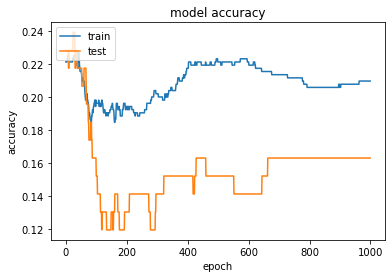

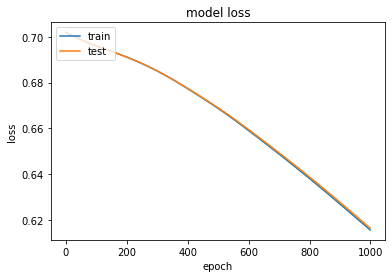

In [55]:
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Investigating ouput layer predictions, as I expected, it's hovering close to 0.5

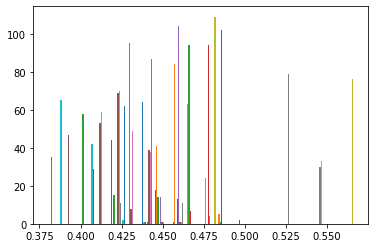

In [59]:
plt.hist(model.predict(X_test));

**Another model**

In [60]:
model = Sequential()
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='tanh',input_shape=(x.shape[1],x.shape[2],x.shape[3])))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512,activation='tanh'))
model.add(Dense(256,activation='tanh'))
model.add(Dense(128,activation='tanh'))
model.add(Dense(y.shape[1],activation='softmax'))

adam=tf.keras.optimizers.Adam(
    learning_rate=0.0000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)

model.compile(optimizer=adam,
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
history = model.fit(X_train,y_train,batch_size=32,epochs=1000,validation_split=0.15,shuffle=True)

Epoch 1/1000
17/17 [==============================] - 1s 33ms/step - loss: 0.3591 - top_k_categorical_accuracy: 0.2365 - val_loss: 0.3599 - val_top_k_categorical_accuracy: 0.2717
Epoch 2/1000
17/17 [==============================] - 0s 26ms/step - loss: 0.3597 - top_k_categorical_accuracy: 0.2462 - val_loss: 0.3598 - val_top_k_categorical_accuracy: 0.2717
Epoch 3/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3600 - top_k_categorical_accuracy: 0.2385 - val_loss: 0.3598 - val_top_k_categorical_accuracy: 0.2717
Epoch 4/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3590 - top_k_categorical_accuracy: 0.2327 - val_loss: 0.3598 - val_top_k_categorical_accuracy: 0.2717
Epoch 5/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3600 - top_k_categorical_accuracy: 0.2192 - val_loss: 0.3597 - val_top_k_categorical_accuracy: 0.2717
Epoch 6/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3596 - top_k_categorical_acc

17/17 [==============================] - 0s 22ms/step - loss: 0.3555 - top_k_categorical_accuracy: 0.2096 - val_loss: 0.3570 - val_top_k_categorical_accuracy: 0.2717
Epoch 92/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3552 - top_k_categorical_accuracy: 0.2192 - val_loss: 0.3570 - val_top_k_categorical_accuracy: 0.2717
Epoch 93/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3549 - top_k_categorical_accuracy: 0.2462 - val_loss: 0.3569 - val_top_k_categorical_accuracy: 0.2717
Epoch 94/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3547 - top_k_categorical_accuracy: 0.2115 - val_loss: 0.3569 - val_top_k_categorical_accuracy: 0.2717
Epoch 95/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3548 - top_k_categorical_accuracy: 0.2231 - val_loss: 0.3569 - val_top_k_categorical_accuracy: 0.2717
Epoch 96/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3545 - top_k_categorical_accuracy: 0

17/17 [==============================] - 0s 23ms/step - loss: 0.3496 - top_k_categorical_accuracy: 0.2231 - val_loss: 0.3541 - val_top_k_categorical_accuracy: 0.2826
Epoch 182/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3509 - top_k_categorical_accuracy: 0.2288 - val_loss: 0.3541 - val_top_k_categorical_accuracy: 0.2826
Epoch 183/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3500 - top_k_categorical_accuracy: 0.2404 - val_loss: 0.3540 - val_top_k_categorical_accuracy: 0.2826
Epoch 184/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.3506 - top_k_categorical_accuracy: 0.2154 - val_loss: 0.3540 - val_top_k_categorical_accuracy: 0.2826
Epoch 185/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.3501 - top_k_categorical_accuracy: 0.2327 - val_loss: 0.3540 - val_top_k_categorical_accuracy: 0.2826
Epoch 186/1000
17/17 [==============================] - 0s 26ms/step - loss: 0.3496 - top_k_categorical_accura

17/17 [==============================] - 0s 23ms/step - loss: 0.3459 - top_k_categorical_accuracy: 0.2423 - val_loss: 0.3511 - val_top_k_categorical_accuracy: 0.2609
Epoch 272/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3451 - top_k_categorical_accuracy: 0.2288 - val_loss: 0.3510 - val_top_k_categorical_accuracy: 0.2609
Epoch 273/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3461 - top_k_categorical_accuracy: 0.2385 - val_loss: 0.3510 - val_top_k_categorical_accuracy: 0.2609
Epoch 274/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3461 - top_k_categorical_accuracy: 0.2269 - val_loss: 0.3510 - val_top_k_categorical_accuracy: 0.2609
Epoch 275/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3458 - top_k_categorical_accuracy: 0.2442 - val_loss: 0.3509 - val_top_k_categorical_accuracy: 0.2609
Epoch 276/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3453 - top_k_categorical_accura

17/17 [==============================] - 0s 23ms/step - loss: 0.3423 - top_k_categorical_accuracy: 0.2577 - val_loss: 0.3478 - val_top_k_categorical_accuracy: 0.2609
Epoch 362/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3412 - top_k_categorical_accuracy: 0.2558 - val_loss: 0.3478 - val_top_k_categorical_accuracy: 0.2609
Epoch 363/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3421 - top_k_categorical_accuracy: 0.2192 - val_loss: 0.3477 - val_top_k_categorical_accuracy: 0.2609
Epoch 364/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.3418 - top_k_categorical_accuracy: 0.2250 - val_loss: 0.3477 - val_top_k_categorical_accuracy: 0.2609
Epoch 365/1000
17/17 [==============================] - 0s 25ms/step - loss: 0.3419 - top_k_categorical_accuracy: 0.2269 - val_loss: 0.3477 - val_top_k_categorical_accuracy: 0.2609
Epoch 366/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3412 - top_k_categorical_accura

17/17 [==============================] - 0s 23ms/step - loss: 0.3383 - top_k_categorical_accuracy: 0.2558 - val_loss: 0.3446 - val_top_k_categorical_accuracy: 0.2717
Epoch 452/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3385 - top_k_categorical_accuracy: 0.2481 - val_loss: 0.3446 - val_top_k_categorical_accuracy: 0.2717
Epoch 453/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3376 - top_k_categorical_accuracy: 0.2615 - val_loss: 0.3445 - val_top_k_categorical_accuracy: 0.2717
Epoch 454/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3369 - top_k_categorical_accuracy: 0.2788 - val_loss: 0.3445 - val_top_k_categorical_accuracy: 0.2717
Epoch 455/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3376 - top_k_categorical_accuracy: 0.2423 - val_loss: 0.3444 - val_top_k_categorical_accuracy: 0.2717
Epoch 456/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3378 - top_k_categorical_accura

17/17 [==============================] - 0s 23ms/step - loss: 0.3356 - top_k_categorical_accuracy: 0.2327 - val_loss: 0.3416 - val_top_k_categorical_accuracy: 0.2609
Epoch 542/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3360 - top_k_categorical_accuracy: 0.2250 - val_loss: 0.3416 - val_top_k_categorical_accuracy: 0.2609
Epoch 543/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3355 - top_k_categorical_accuracy: 0.2827 - val_loss: 0.3415 - val_top_k_categorical_accuracy: 0.2609
Epoch 544/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3365 - top_k_categorical_accuracy: 0.2192 - val_loss: 0.3415 - val_top_k_categorical_accuracy: 0.2609
Epoch 545/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3351 - top_k_categorical_accuracy: 0.2692 - val_loss: 0.3415 - val_top_k_categorical_accuracy: 0.2609
Epoch 546/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3344 - top_k_categorical_accura

17/17 [==============================] - 0s 24ms/step - loss: 0.3346 - top_k_categorical_accuracy: 0.2558 - val_loss: 0.3390 - val_top_k_categorical_accuracy: 0.2717
Epoch 632/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3335 - top_k_categorical_accuracy: 0.2788 - val_loss: 0.3390 - val_top_k_categorical_accuracy: 0.2717
Epoch 633/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3330 - top_k_categorical_accuracy: 0.2769 - val_loss: 0.3390 - val_top_k_categorical_accuracy: 0.2717
Epoch 634/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3345 - top_k_categorical_accuracy: 0.2442 - val_loss: 0.3389 - val_top_k_categorical_accuracy: 0.2717
Epoch 635/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.3335 - top_k_categorical_accuracy: 0.2500 - val_loss: 0.3389 - val_top_k_categorical_accuracy: 0.2717
Epoch 636/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.3330 - top_k_categorical_accura

17/17 [==============================] - 0s 23ms/step - loss: 0.3310 - top_k_categorical_accuracy: 0.2596 - val_loss: 0.3370 - val_top_k_categorical_accuracy: 0.2826
Epoch 722/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3318 - top_k_categorical_accuracy: 0.2788 - val_loss: 0.3369 - val_top_k_categorical_accuracy: 0.2826
Epoch 723/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3312 - top_k_categorical_accuracy: 0.2731 - val_loss: 0.3369 - val_top_k_categorical_accuracy: 0.2826
Epoch 724/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3316 - top_k_categorical_accuracy: 0.2577 - val_loss: 0.3369 - val_top_k_categorical_accuracy: 0.2826
Epoch 725/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3313 - top_k_categorical_accuracy: 0.2808 - val_loss: 0.3369 - val_top_k_categorical_accuracy: 0.2826
Epoch 726/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3314 - top_k_categorical_accura

17/17 [==============================] - 0s 25ms/step - loss: 0.3305 - top_k_categorical_accuracy: 0.2635 - val_loss: 0.3354 - val_top_k_categorical_accuracy: 0.2935
Epoch 812/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.3311 - top_k_categorical_accuracy: 0.2615 - val_loss: 0.3354 - val_top_k_categorical_accuracy: 0.2935
Epoch 813/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3302 - top_k_categorical_accuracy: 0.2808 - val_loss: 0.3353 - val_top_k_categorical_accuracy: 0.2935
Epoch 814/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.3313 - top_k_categorical_accuracy: 0.2731 - val_loss: 0.3353 - val_top_k_categorical_accuracy: 0.2935
Epoch 815/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3313 - top_k_categorical_accuracy: 0.2692 - val_loss: 0.3353 - val_top_k_categorical_accuracy: 0.2935
Epoch 816/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3306 - top_k_categorical_accura

17/17 [==============================] - 0s 23ms/step - loss: 0.3292 - top_k_categorical_accuracy: 0.2846 - val_loss: 0.3342 - val_top_k_categorical_accuracy: 0.2935
Epoch 902/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.3307 - top_k_categorical_accuracy: 0.2788 - val_loss: 0.3342 - val_top_k_categorical_accuracy: 0.2935
Epoch 903/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3305 - top_k_categorical_accuracy: 0.2596 - val_loss: 0.3342 - val_top_k_categorical_accuracy: 0.2935
Epoch 904/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3302 - top_k_categorical_accuracy: 0.2596 - val_loss: 0.3341 - val_top_k_categorical_accuracy: 0.2935
Epoch 905/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3289 - top_k_categorical_accuracy: 0.2942 - val_loss: 0.3341 - val_top_k_categorical_accuracy: 0.2935
Epoch 906/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3301 - top_k_categorical_accura

17/17 [==============================] - 0s 24ms/step - loss: 0.3281 - top_k_categorical_accuracy: 0.2846 - val_loss: 0.3332 - val_top_k_categorical_accuracy: 0.2935
Epoch 992/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.3297 - top_k_categorical_accuracy: 0.2731 - val_loss: 0.3332 - val_top_k_categorical_accuracy: 0.2935
Epoch 993/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3297 - top_k_categorical_accuracy: 0.2635 - val_loss: 0.3332 - val_top_k_categorical_accuracy: 0.2935
Epoch 994/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3298 - top_k_categorical_accuracy: 0.2769 - val_loss: 0.3332 - val_top_k_categorical_accuracy: 0.2935
Epoch 995/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3303 - top_k_categorical_accuracy: 0.2923 - val_loss: 0.3332 - val_top_k_categorical_accuracy: 0.2935
Epoch 996/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.3294 - top_k_categorical_accura

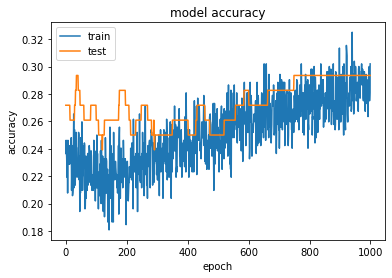

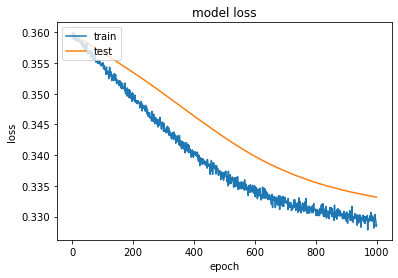

In [61]:
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Here, I decided to give more range to the final layer's output by scaling y to (-1,1) and using a Tanh output activation function instead

In [89]:
new_y = np.where(y==0, -1, y)

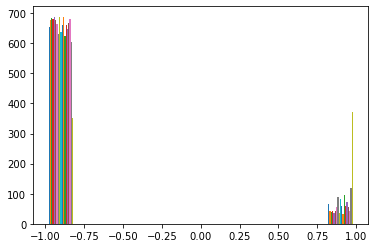

In [91]:
plt.hist(new_y);

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
     x, new_y, test_size=0.1, random_state=42)

Build and compile final model with MSE loss and tanh activation in final layer, very deep model (with perhaps too much?) dropout

In [ ]:
model = Sequential()
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='tanh',input_shape=(x.shape[1],x.shape[2],x.shape[3])))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(1024,activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(512,activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(256,activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(128,activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(64,activation='tanh'))
model.add(Dense(y.shape[1],activation='tanh'))

adam=tf.keras.optimizers.Adam(
    learning_rate=0.000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)

model.compile(optimizer=adam,
              loss="mse",
              metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(X_train,y_train,batch_size=128,epochs=2000,validation_split=0.1,shuffle=True)

Epoch 1/2000
5/5 [==============================] - 0s 95ms/step - loss: 1.0636 - mean_absolute_error: 1.0054 - val_loss: 0.9994 - val_mean_absolute_error: 0.9983
Epoch 2/2000
5/5 [==============================] - 0s 66ms/step - loss: 1.0499 - mean_absolute_error: 0.9993 - val_loss: 0.9954 - val_mean_absolute_error: 0.9963
Epoch 3/2000
5/5 [==============================] - 0s 65ms/step - loss: 1.0453 - mean_absolute_error: 0.9972 - val_loss: 0.9913 - val_mean_absolute_error: 0.9942
Epoch 4/2000
5/5 [==============================] - 0s 66ms/step - loss: 1.0385 - mean_absolute_error: 0.9933 - val_loss: 0.9874 - val_mean_absolute_error: 0.9922
Epoch 5/2000
5/5 [==============================] - 0s 64ms/step - loss: 1.0336 - mean_absolute_error: 0.9913 - val_loss: 0.9834 - val_mean_absolute_error: 0.9902
Epoch 6/2000
5/5 [==============================] - 0s 66ms/step - loss: 1.0321 - mean_absolute_error: 0.9905 - val_loss: 0.9795 - val_mean_absolute_error: 0.9882
Epoch 7/2000
5/5 [====

5/5 [==============================] - 0s 65ms/step - loss: 0.8075 - mean_absolute_error: 0.8584 - val_loss: 0.8137 - val_mean_absolute_error: 0.8948
Epoch 52/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.8088 - mean_absolute_error: 0.8589 - val_loss: 0.8100 - val_mean_absolute_error: 0.8924
Epoch 53/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.8065 - mean_absolute_error: 0.8558 - val_loss: 0.8062 - val_mean_absolute_error: 0.8901
Epoch 54/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.8031 - mean_absolute_error: 0.8541 - val_loss: 0.8025 - val_mean_absolute_error: 0.8878
Epoch 55/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.7993 - mean_absolute_error: 0.8508 - val_loss: 0.7988 - val_mean_absolute_error: 0.8854
Epoch 56/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.7979 - mean_absolute_error: 0.8504 - val_loss: 0.7951 - val_mean_absolute_error: 0.8831
Epoch 57/2000
5/5 [===========

5/5 [==============================] - 0s 73ms/step - loss: 0.6482 - mean_absolute_error: 0.7312 - val_loss: 0.6391 - val_mean_absolute_error: 0.7723
Epoch 102/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.6503 - mean_absolute_error: 0.7321 - val_loss: 0.6360 - val_mean_absolute_error: 0.7699
Epoch 103/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.6439 - mean_absolute_error: 0.7267 - val_loss: 0.6330 - val_mean_absolute_error: 0.7675
Epoch 104/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.6461 - mean_absolute_error: 0.7287 - val_loss: 0.6300 - val_mean_absolute_error: 0.7651
Epoch 105/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.6350 - mean_absolute_error: 0.7204 - val_loss: 0.6270 - val_mean_absolute_error: 0.7626
Epoch 106/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.6355 - mean_absolute_error: 0.7212 - val_loss: 0.6241 - val_mean_absolute_error: 0.7602
Epoch 107/2000
5/5 [=====

Epoch 151/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.5489 - mean_absolute_error: 0.6359 - val_loss: 0.5146 - val_mean_absolute_error: 0.6601
Epoch 152/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.5447 - mean_absolute_error: 0.6351 - val_loss: 0.5126 - val_mean_absolute_error: 0.6581
Epoch 153/2000
5/5 [==============================] - 0s 70ms/step - loss: 0.5388 - mean_absolute_error: 0.6293 - val_loss: 0.5107 - val_mean_absolute_error: 0.6561
Epoch 154/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.5461 - mean_absolute_error: 0.6333 - val_loss: 0.5088 - val_mean_absolute_error: 0.6541
Epoch 155/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.5426 - mean_absolute_error: 0.6316 - val_loss: 0.5070 - val_mean_absolute_error: 0.6522
Epoch 156/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.5469 - mean_absolute_error: 0.6325 - val_loss: 0.5051 - val_mean_absolute_error: 0.6502
Epoch 157/

Epoch 201/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4856 - mean_absolute_error: 0.5664 - val_loss: 0.4400 - val_mean_absolute_error: 0.5733
Epoch 202/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4892 - mean_absolute_error: 0.5685 - val_loss: 0.4389 - val_mean_absolute_error: 0.5718
Epoch 203/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.4871 - mean_absolute_error: 0.5671 - val_loss: 0.4378 - val_mean_absolute_error: 0.5703
Epoch 204/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4882 - mean_absolute_error: 0.5661 - val_loss: 0.4367 - val_mean_absolute_error: 0.5689
Epoch 205/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.4856 - mean_absolute_error: 0.5638 - val_loss: 0.4356 - val_mean_absolute_error: 0.5674
Epoch 206/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.4844 - mean_absolute_error: 0.5631 - val_loss: 0.4345 - val_mean_absolute_error: 0.5660
Epoch 207/

Epoch 251/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.4509 - mean_absolute_error: 0.5230 - val_loss: 0.3970 - val_mean_absolute_error: 0.5094
Epoch 252/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4417 - mean_absolute_error: 0.5162 - val_loss: 0.3964 - val_mean_absolute_error: 0.5083
Epoch 253/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4492 - mean_absolute_error: 0.5164 - val_loss: 0.3957 - val_mean_absolute_error: 0.5072
Epoch 254/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4537 - mean_absolute_error: 0.5223 - val_loss: 0.3951 - val_mean_absolute_error: 0.5062
Epoch 255/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.4520 - mean_absolute_error: 0.5187 - val_loss: 0.3945 - val_mean_absolute_error: 0.5051
Epoch 256/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4523 - mean_absolute_error: 0.5197 - val_loss: 0.3939 - val_mean_absolute_error: 0.5040
Epoch 257/

Epoch 301/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4246 - mean_absolute_error: 0.4851 - val_loss: 0.3722 - val_mean_absolute_error: 0.4622
Epoch 302/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4271 - mean_absolute_error: 0.4857 - val_loss: 0.3718 - val_mean_absolute_error: 0.4614
Epoch 303/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.4272 - mean_absolute_error: 0.4871 - val_loss: 0.3714 - val_mean_absolute_error: 0.4605
Epoch 304/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4254 - mean_absolute_error: 0.4817 - val_loss: 0.3711 - val_mean_absolute_error: 0.4597
Epoch 305/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4236 - mean_absolute_error: 0.4823 - val_loss: 0.3707 - val_mean_absolute_error: 0.4590
Epoch 306/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.4218 - mean_absolute_error: 0.4817 - val_loss: 0.3704 - val_mean_absolute_error: 0.4582
Epoch 307/

Epoch 351/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4114 - mean_absolute_error: 0.4569 - val_loss: 0.3577 - val_mean_absolute_error: 0.4273
Epoch 352/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4097 - mean_absolute_error: 0.4564 - val_loss: 0.3575 - val_mean_absolute_error: 0.4267
Epoch 353/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.4089 - mean_absolute_error: 0.4593 - val_loss: 0.3573 - val_mean_absolute_error: 0.4261
Epoch 354/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.4055 - mean_absolute_error: 0.4548 - val_loss: 0.3571 - val_mean_absolute_error: 0.4256
Epoch 355/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4054 - mean_absolute_error: 0.4542 - val_loss: 0.3569 - val_mean_absolute_error: 0.4250
Epoch 356/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.4053 - mean_absolute_error: 0.4534 - val_loss: 0.3567 - val_mean_absolute_error: 0.4244
Epoch 357/

Epoch 401/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3995 - mean_absolute_error: 0.4383 - val_loss: 0.3491 - val_mean_absolute_error: 0.4008
Epoch 402/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3978 - mean_absolute_error: 0.4374 - val_loss: 0.3490 - val_mean_absolute_error: 0.4004
Epoch 403/2000
5/5 [==============================] - 0s 71ms/step - loss: 0.4002 - mean_absolute_error: 0.4399 - val_loss: 0.3489 - val_mean_absolute_error: 0.3999
Epoch 404/2000
5/5 [==============================] - 0s 71ms/step - loss: 0.4004 - mean_absolute_error: 0.4396 - val_loss: 0.3487 - val_mean_absolute_error: 0.3995
Epoch 405/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3948 - mean_absolute_error: 0.4347 - val_loss: 0.3486 - val_mean_absolute_error: 0.3990
Epoch 406/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.4004 - mean_absolute_error: 0.4381 - val_loss: 0.3485 - val_mean_absolute_error: 0.3986
Epoch 407/

Epoch 451/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3858 - mean_absolute_error: 0.4196 - val_loss: 0.3439 - val_mean_absolute_error: 0.3805
Epoch 452/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3902 - mean_absolute_error: 0.4204 - val_loss: 0.3438 - val_mean_absolute_error: 0.3801
Epoch 453/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3886 - mean_absolute_error: 0.4185 - val_loss: 0.3437 - val_mean_absolute_error: 0.3798
Epoch 454/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3884 - mean_absolute_error: 0.4208 - val_loss: 0.3437 - val_mean_absolute_error: 0.3794
Epoch 455/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3899 - mean_absolute_error: 0.4201 - val_loss: 0.3436 - val_mean_absolute_error: 0.3791
Epoch 456/2000
5/5 [==============================] - 0s 63ms/step - loss: 0.3910 - mean_absolute_error: 0.4201 - val_loss: 0.3435 - val_mean_absolute_error: 0.3787
Epoch 457/

Epoch 503/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3804 - mean_absolute_error: 0.4055 - val_loss: 0.3406 - val_mean_absolute_error: 0.3641
Epoch 504/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3819 - mean_absolute_error: 0.4054 - val_loss: 0.3406 - val_mean_absolute_error: 0.3638
Epoch 505/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3886 - mean_absolute_error: 0.4112 - val_loss: 0.3405 - val_mean_absolute_error: 0.3636
Epoch 506/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3853 - mean_absolute_error: 0.4080 - val_loss: 0.3405 - val_mean_absolute_error: 0.3633
Epoch 507/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3776 - mean_absolute_error: 0.4029 - val_loss: 0.3405 - val_mean_absolute_error: 0.3630
Epoch 508/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3865 - mean_absolute_error: 0.4092 - val_loss: 0.3404 - val_mean_absolute_error: 0.3627
Epoch 509/

Epoch 553/2000
5/5 [==============================] - 0s 74ms/step - loss: 0.3751 - mean_absolute_error: 0.3926 - val_loss: 0.3387 - val_mean_absolute_error: 0.3516
Epoch 554/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3745 - mean_absolute_error: 0.3924 - val_loss: 0.3387 - val_mean_absolute_error: 0.3514
Epoch 555/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3726 - mean_absolute_error: 0.3917 - val_loss: 0.3387 - val_mean_absolute_error: 0.3512
Epoch 556/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3752 - mean_absolute_error: 0.3923 - val_loss: 0.3386 - val_mean_absolute_error: 0.3510
Epoch 557/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3797 - mean_absolute_error: 0.3961 - val_loss: 0.3386 - val_mean_absolute_error: 0.3508
Epoch 558/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3770 - mean_absolute_error: 0.3935 - val_loss: 0.3386 - val_mean_absolute_error: 0.3505
Epoch 559/

Epoch 603/2000
5/5 [==============================] - 0s 70ms/step - loss: 0.3725 - mean_absolute_error: 0.3834 - val_loss: 0.3376 - val_mean_absolute_error: 0.3415
Epoch 604/2000
5/5 [==============================] - 0s 77ms/step - loss: 0.3741 - mean_absolute_error: 0.3849 - val_loss: 0.3375 - val_mean_absolute_error: 0.3413
Epoch 605/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3747 - mean_absolute_error: 0.3877 - val_loss: 0.3375 - val_mean_absolute_error: 0.3411
Epoch 606/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3759 - mean_absolute_error: 0.3868 - val_loss: 0.3375 - val_mean_absolute_error: 0.3409
Epoch 607/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3721 - mean_absolute_error: 0.3840 - val_loss: 0.3375 - val_mean_absolute_error: 0.3407
Epoch 608/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3747 - mean_absolute_error: 0.3844 - val_loss: 0.3374 - val_mean_absolute_error: 0.3405
Epoch 609/

Epoch 653/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3717 - mean_absolute_error: 0.3781 - val_loss: 0.3368 - val_mean_absolute_error: 0.3330
Epoch 654/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3679 - mean_absolute_error: 0.3767 - val_loss: 0.3368 - val_mean_absolute_error: 0.3329
Epoch 655/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3724 - mean_absolute_error: 0.3797 - val_loss: 0.3368 - val_mean_absolute_error: 0.3327
Epoch 656/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3693 - mean_absolute_error: 0.3766 - val_loss: 0.3368 - val_mean_absolute_error: 0.3325
Epoch 657/2000
5/5 [==============================] - 0s 73ms/step - loss: 0.3709 - mean_absolute_error: 0.3769 - val_loss: 0.3368 - val_mean_absolute_error: 0.3324
Epoch 658/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3699 - mean_absolute_error: 0.3765 - val_loss: 0.3368 - val_mean_absolute_error: 0.3322
Epoch 659/

Epoch 703/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3663 - mean_absolute_error: 0.3691 - val_loss: 0.3365 - val_mean_absolute_error: 0.3258
Epoch 704/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3681 - mean_absolute_error: 0.3698 - val_loss: 0.3365 - val_mean_absolute_error: 0.3257
Epoch 705/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3666 - mean_absolute_error: 0.3669 - val_loss: 0.3365 - val_mean_absolute_error: 0.3256
Epoch 706/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3629 - mean_absolute_error: 0.3650 - val_loss: 0.3365 - val_mean_absolute_error: 0.3255
Epoch 707/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3704 - mean_absolute_error: 0.3700 - val_loss: 0.3365 - val_mean_absolute_error: 0.3253
Epoch 708/2000
5/5 [==============================] - 0s 70ms/step - loss: 0.3681 - mean_absolute_error: 0.3685 - val_loss: 0.3365 - val_mean_absolute_error: 0.3252
Epoch 709/

Epoch 753/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3652 - mean_absolute_error: 0.3612 - val_loss: 0.3362 - val_mean_absolute_error: 0.3200
Epoch 754/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3681 - mean_absolute_error: 0.3646 - val_loss: 0.3362 - val_mean_absolute_error: 0.3199
Epoch 755/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3628 - mean_absolute_error: 0.3609 - val_loss: 0.3362 - val_mean_absolute_error: 0.3198
Epoch 756/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3663 - mean_absolute_error: 0.3629 - val_loss: 0.3362 - val_mean_absolute_error: 0.3196
Epoch 757/2000
5/5 [==============================] - 0s 63ms/step - loss: 0.3646 - mean_absolute_error: 0.3614 - val_loss: 0.3362 - val_mean_absolute_error: 0.3195
Epoch 758/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3643 - mean_absolute_error: 0.3617 - val_loss: 0.3362 - val_mean_absolute_error: 0.3194
Epoch 759/

Epoch 803/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3615 - mean_absolute_error: 0.3567 - val_loss: 0.3362 - val_mean_absolute_error: 0.3150
Epoch 804/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3640 - mean_absolute_error: 0.3577 - val_loss: 0.3362 - val_mean_absolute_error: 0.3149
Epoch 805/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3632 - mean_absolute_error: 0.3570 - val_loss: 0.3362 - val_mean_absolute_error: 0.3149
Epoch 806/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3617 - mean_absolute_error: 0.3559 - val_loss: 0.3362 - val_mean_absolute_error: 0.3148
Epoch 807/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3659 - mean_absolute_error: 0.3580 - val_loss: 0.3362 - val_mean_absolute_error: 0.3147
Epoch 808/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3643 - mean_absolute_error: 0.3572 - val_loss: 0.3362 - val_mean_absolute_error: 0.3146
Epoch 809/

Epoch 853/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3581 - mean_absolute_error: 0.3487 - val_loss: 0.3362 - val_mean_absolute_error: 0.3106
Epoch 854/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3608 - mean_absolute_error: 0.3515 - val_loss: 0.3362 - val_mean_absolute_error: 0.3106
Epoch 855/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3666 - mean_absolute_error: 0.3549 - val_loss: 0.3362 - val_mean_absolute_error: 0.3105
Epoch 856/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3600 - mean_absolute_error: 0.3496 - val_loss: 0.3362 - val_mean_absolute_error: 0.3104
Epoch 857/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3574 - mean_absolute_error: 0.3488 - val_loss: 0.3362 - val_mean_absolute_error: 0.3103
Epoch 858/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3604 - mean_absolute_error: 0.3510 - val_loss: 0.3362 - val_mean_absolute_error: 0.3103
Epoch 859/

Epoch 903/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3599 - mean_absolute_error: 0.3480 - val_loss: 0.3361 - val_mean_absolute_error: 0.3070
Epoch 904/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3618 - mean_absolute_error: 0.3495 - val_loss: 0.3361 - val_mean_absolute_error: 0.3069
Epoch 905/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3612 - mean_absolute_error: 0.3478 - val_loss: 0.3361 - val_mean_absolute_error: 0.3068
Epoch 906/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3608 - mean_absolute_error: 0.3483 - val_loss: 0.3361 - val_mean_absolute_error: 0.3068
Epoch 907/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3578 - mean_absolute_error: 0.3455 - val_loss: 0.3361 - val_mean_absolute_error: 0.3067
Epoch 908/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3615 - mean_absolute_error: 0.3473 - val_loss: 0.3361 - val_mean_absolute_error: 0.3066
Epoch 909/

Epoch 953/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3560 - mean_absolute_error: 0.3408 - val_loss: 0.3362 - val_mean_absolute_error: 0.3038
Epoch 954/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3597 - mean_absolute_error: 0.3447 - val_loss: 0.3362 - val_mean_absolute_error: 0.3038
Epoch 955/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3580 - mean_absolute_error: 0.3434 - val_loss: 0.3362 - val_mean_absolute_error: 0.3037
Epoch 956/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3618 - mean_absolute_error: 0.3431 - val_loss: 0.3362 - val_mean_absolute_error: 0.3036
Epoch 957/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3616 - mean_absolute_error: 0.3432 - val_loss: 0.3362 - val_mean_absolute_error: 0.3036
Epoch 958/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3594 - mean_absolute_error: 0.3433 - val_loss: 0.3362 - val_mean_absolute_error: 0.3035
Epoch 959/

5/5 [==============================] - 0s 65ms/step - loss: 0.3571 - mean_absolute_error: 0.3353 - val_loss: 0.3362 - val_mean_absolute_error: 0.2984
Epoch 1052/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3586 - mean_absolute_error: 0.3376 - val_loss: 0.3362 - val_mean_absolute_error: 0.2984
Epoch 1053/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3544 - mean_absolute_error: 0.3353 - val_loss: 0.3362 - val_mean_absolute_error: 0.2983
Epoch 1054/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3563 - mean_absolute_error: 0.3361 - val_loss: 0.3362 - val_mean_absolute_error: 0.2983
Epoch 1055/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3592 - mean_absolute_error: 0.3384 - val_loss: 0.3362 - val_mean_absolute_error: 0.2983
Epoch 1056/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3550 - mean_absolute_error: 0.3364 - val_loss: 0.3362 - val_mean_absolute_error: 0.2982
Epoch 1057/2000
5/5 

Last training curve plots

In [ ]:
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
preds=model.predict(X_test)

In [ ]:
two_max_args = []
for i in range(preds.shape[0]):
    